# Reading ISMN data (`ismn.interface.ISMN_Interface`)
This example shows the basic functionality to read data downloaded from the International Soil Moisture Network (ISMN).
The data can be selected and downloaded for free from <http://ismn.earth> after registration.

For this tutorial, data (all available variables) for ISMN networks 'REMEDHUS', 'SMOSMANIA', 'FMI', 'WEGENERNET', 'GTK', 'VAS' and 'RSMN' between 2009-08-04 and 2020-12-12 was downloaded from the ISMN website. Note that - depending on when you download the data  - available stations and measurement values can vary slightly from those shown in this example.

<img src="ismn.png" style="height: 450px;"/>

ISMN files are downloaded as a compressed `.zip` file after selecting the data from the website. You can extract it (with any zip software) locally into one (root) folder (in this case 'Data_separate_files'). The will be organised like this:
```shell
Data_separate_files/
├── network/
│   ├── station/
│   │   ├── sensor.stm
│   │   ├── sensor.stm
│   │   ├── ...
│   │   ├── sensor.stm
│   │   ├── static_variables.csv
│   ├── station/
│   │   ├── ...
├── network/
│   ├── ...
├── ISMN_qualityflags_description.txt
├── Metadata.xml
├── Provider_qualityflags_description.txt
└── Readme.txt
```
You can either read from this extracted root folder, or read from the .zip file directly (the reader will then unzip files temporarily when needed). Reading from zip is therefore slower than reading the extracted files. Extracted files are (much) larger than compressed files.

The class for reading data from extracted or compressed files is `ismn.interface.ISMN_Interface`. It provides functions to access single networks, stations and sensors and the measured time series for each sensor as well as metadata for each station/sensor.

`ISMN_Interface` expects the path to the downloaded and locally stored ISMN data (zip-file or extracted root folder) as the only required argument.

In [1]:
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
%matplotlib inline

# Either a .zip file or one folder that contains all networks, here we read from .zip
data_path = "/tmp/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.zip"
ismn_data = ISMN_Interface(data_path)

Processing metadata for all ismn stations into folder /tmp/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.zip.
This may take a few minutes, but is only done once...
Hint: Use `parallel=True` to speed up metadata generation for large datasets


Files Processed: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:09<00:00, 12.06it/s]


Metadata generation finished after 9 Seconds.
Metadata and Log stored in /tmp/python_metadata
Found existing ismn metadata in /tmp/python_metadata/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.csv.


The first time you initialize `ISMN_Interface` for a dataset, it will collect metadata for all sensors in your data collection from various files (this is **always** done for **all** available networks). The program will iterate through **all** files and collect information such as station names, sensor time coverage, measurement depths, landcover/climate classes, soil properties etc. for each sensor. Depending on the number of files and whether zipped/extracted files are used, this step can take a while. A log file is created in the displayed path. Parallel processing for this step can be activated manually by choosing `ISMN_Interface(data_path, parallel=True)` and will speed up metadata collection significantly. By default this step will create a folder called `python_metadata` (which contains the collected metadata as a `.csv` file) and place it inside the passed root directory. The next time the reader is created it will use `python_metadata` (if it is found) instead of generating it again (a different path to generate and search the metadata in can be passed via `ISMN_Interface(data_path, meta_path='/custom/meta/path')`.

**Note: When changing the data (e.g. if you add or remove folders from the collection that is passed to the reader) make sure to delete the `python_metadata` folder and its content to force re-generating it. Otherwise data and metadata won't match anymore!!**

To limit reading to a selection of networks from the beginning (e.g. to load one network from a large collection, which is faster than loading all networks and then selecting one), their names can be passed to the reader (e.g. `ISMN_Interface(data_path, network=['REMEDHUS', 'SMOSMANIA'])`. Otherwise, all networks stored under the given path are loaded. Limiting the number of networks when calling the reader will result in faster initialization, because less files are loaded (this does **not** affect the one-time metadata collection, which is always done for all networks in `data_path`).

You can call `ISMN_Interface(data_path, keep_loaded_data=True)`, which will cause that all sensor time series - once read - are kept in memory for faster subsequent calls. This can fill up your memory and is only recommended for small data collections, respectively if only a few networks are initialized.

Finally, you can define a custom temporary root folder, e.g. `ISMN_Interface(data_path, temp_root='/tmp/my_tempdata')`. By default this depends on your OS (e.g. `/tmp` for Linux), and is used by the reader to store some temporary files, e.g. when extracting while reading from `.zip`. The default `temp_root` is cleared automatically by your OS, so we recommend not to change this (unless necessary e.g. because of access restrictions).

## ISMN Components (Overview)
Here we give a short overview over the components that build a ISMN data set. Each component provides various functions to work with its data and access sub-components. See the python module docs for more details. This is just a basic overview of how to pick data out of the collection. In practice, it is often required to loop over certain stations. This is described later in this tutorial. The components (hierarchically ordered) are `NetworkCollection` <- `Network(s)` <- `Station(s)` <- `Sensor(s)`.

### Collection
The `ISMN_Interface` object holds all loaded networks (e.g. 'FMI', 'REMEDHUS', ...). Each Network contains multiple Stations (e.g. 'SAA111', 'SA112', ... for the 'FMI' network). Each Station contains multiple Sensors (names not shown in this overview). You can access Networks directly from the reader, and subsequently access Stations and their Sensors.

In [2]:
ismn_data

ismn.base.IsmnRoot Zip at /tmp/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.zip
with Networks[Stations]:
------------------------
  FMI: ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS'],
  GTK: ['IlomantsiII', 'Kuusamo', 'PoriII', 'Suomussalmi'],
  REMEDHUS: ['Canizal', 'Carramedina', 'Carretoro', 'CasaPeriles', 'ConcejodelMonte', 'ElCoto', 'ElTomillar', 'Granja-g', 'Guarena', 'Guarrati', 'LaAtalaya', 'LaCruzdeElias', 'LasArenas', 'LasBodegas', 'LasBrozas', 'LasEritas', 'LasTresRayas', 'LasVacas', 'LasVictorias', 'LlanosdelaBoveda', 'Paredinas', 'Zamarron'],
  RSMN: ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'Sannicol

### Network

You can select a specific network from the collection above via its name. Here we pick the network 'SMOSMANIA' from our loaded set. Networks are sorted alphabetically, so you can also pass a number here, e.g. `ismn_data[4]` to get the fourth network from the list. This will (again) display all stations for that network.
Note that we can call a network directly from `ismn_data` without using the collection.

In [3]:
ismn_data['SMOSMANIA']  #  overview over stations in SMOSMANIA network; same as ismn_data[4]

Network 'SMOSMANIA' with Stations: ['Barnas', 'Berzeme', 'CabrieresdAvignon', 'Condom', 'CreondArmagnac', 'LaGrandCombe', 'Lahas', 'LezignanCorbieres', 'Mazan-Abbaye', 'Mejannes-le-Clap', 'Montaut', 'Mouthoumet', 'Narbonne', 'PeyrusseGrande', 'Pezenas', 'Pezenas-old', 'Prades-le-Lez', 'Sabres', 'SaintFelixdeLauragais', 'Savenes', 'Urgons', 'Villevielle']

### Station

A network consists of multiple stations, multiple variables can be measured by different sensors at a station. You can select a specific station for a network via its name (stations are also sorted alphabetically and can be accessed by index). Here we access the Station 'Saint_Felix_de_Lauragais' from the 'SMOSMANIA' network.

In [5]:
ismn_data['SMOSMANIA']['SaintFelixdeLauragais']  #  overview over sensors at Saint_Felix_de_Lauragais; same as ismn_data[4][18]

Station 'SaintFelixdeLauragais' with Sensors: ['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000', 'PT-100_soil_temperature_0.050000_0.050000', 'ThetaProbe-ML2X_soil_moisture_0.100000_0.100000', 'PT-100_soil_temperature_0.100000_0.100000', 'ThetaProbe-ML2X_soil_moisture_0.200000_0.200000', 'PT-100_soil_temperature_0.200000_0.200000', 'ThetaProbe-ML2X_soil_moisture_0.300000_0.300000', 'PT-100_soil_temperature_0.300000_0.300000', 'ThetaProbe-ML3_soil_moisture_0.200000_0.200000']

Each station has a metadata attribute. The station metadata contains all metadata variables from all sensors that measure at the station (such as the sensor type, soil properties etc. per sensor). Therefore, the station metadata can be different for different depths. You can call `MetaData` directly, or convert it to either a DataFrame (`MetaData.to_pd()`) or a dictionary (`MetaData.to_dict()`) of form:

```
{var_name: [(value, depth_from, depth_to), 
            ...], 
...}
```

In the example below, we read metadata without conversion. The first value in each Variable is the name of the metadata variable, the second the actual value for the variable. The third value is the depth range (depth_from, depth_to) that the value applies to - e.g. for soil properties (taken from the Harmonized World Soil Data Base) multiple layers are provided together with the ISMN data and during metadata generation the best matching depth for a sensor is selected. Some values apply to a specific depth (depth_from=depth_to) while others may apply to a depth range (usually depends on the network).

In [6]:
ismn_data['SMOSMANIA']['SaintFelixdeLauragais'].metadata  #  Get metadata for the station

MetaData([
  MetaVar([clay_fraction, 22.8, Depth([0.05, 0.05])]),
  MetaVar([climate_KG, Cfb, None]),
  MetaVar([climate_insitu, unknown, None]),
  MetaVar([elevation, 337.0, None]),
  MetaVar([instrument, ThetaProbe-ML2X, Depth([0.05, 0.05])]),
  MetaVar([latitude, 43.4417, None]),
  MetaVar([lc_2000, 10, None]),
  MetaVar([lc_2005, 10, None]),
  MetaVar([lc_2010, 10, None]),
  MetaVar([lc_insitu, unknown, None]),
  MetaVar([longitude, 1.88, None]),
  MetaVar([network, SMOSMANIA, None]),
  MetaVar([organic_carbon, 1.15, Depth([0.05, 0.05])]),
  MetaVar([sand_fraction, 43.5, Depth([0.05, 0.05])]),
  MetaVar([saturation, 0.44, Depth([0.05, 0.05])]),
  MetaVar([silt_fraction, 33.7, Depth([0.05, 0.05])]),
  MetaVar([station, SaintFelixdeLauragais, None]),
  MetaVar([timerange_from, 2009-01-01 00:00:00, None]),
  MetaVar([timerange_to, 2020-12-31 23:00:00, None]),
  MetaVar([variable, soil_moisture, Depth([0.05, 0.05])]),
  MetaVar([instrument, PT-100, Depth([0.05, 0.05])]),
  MetaVar([var

### Sensor

Accessing sensors at a station works similar to accessing stations in a network. By default, the name is created from the instrument type, the measured variable and the depth layer that the sensor operates in.

In [7]:
ismn_data['SMOSMANIA']['SaintFelixdeLauragais']['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000'] #  equivalent to ismn_data[4][18][4]

ThetaProbe-ML2X_soil_moisture_0.050000_0.050000

Each sensor has a measurement time series (access via `Sensor.data`) and sensor specific metadata (via `Sensor.metadata`) assigned. Here we convert metadata to a data frame.

variable        key       
clay_fraction   val                            22.8
                depth_from                     0.05
                depth_to                       0.05
climate_KG      val                             Cfb
climate_insitu  val                         unknown
elevation       val                           337.0
instrument      val                 ThetaProbe-ML2X
                depth_from                     0.05
                depth_to                       0.05
latitude        val                         43.4417
lc_2000         val                              10
lc_2005         val                              10
lc_2010         val                              10
lc_insitu       val                         unknown
longitude       val                            1.88
network         val                       SMOSMANIA
organic_carbon  val                            1.15
                depth_from                     0.05
                depth_to             

Text(0, 0.5, 'Soil Moisture [$m^3 m^{-3}$]')

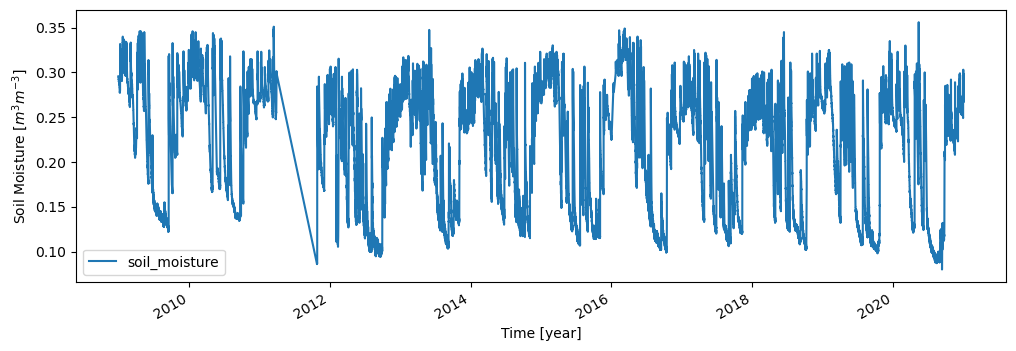

In [8]:
sensor = ismn_data['SMOSMANIA']['SaintFelixdeLauragais']['ThetaProbe-ML2X_soil_moisture_0.050000_0.050000']
print(sensor.metadata.to_pd())
ax = sensor.data.plot(figsize=(12,4))
ax.set_xlabel("Time [year]")
ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")

Some metadata is different for each sensor (e.g. time series range), some depends on the location of the station and is therefore shared by multiple sensors at one station (landcover and climate classes etc.). Sometime metadata is missing (if not provided, indicated by 'unknown', or NaN). Some meta data depends on the depth of a sensor (e.g. soil properties), during metadata collection (in the beginning) these values were collected and assigned.

In [9]:
sensor.metadata.to_dict()

{'clay_fraction': [(22.8, 0.05, 0.05)],
 'climate_KG': [('Cfb', None, None)],
 'climate_insitu': [('unknown', None, None)],
 'elevation': [(337.0, None, None)],
 'instrument': [('ThetaProbe-ML2X', 0.05, 0.05)],
 'latitude': [(43.4417, None, None)],
 'lc_2000': [(10, None, None)],
 'lc_2005': [(10, None, None)],
 'lc_2010': [(10, None, None)],
 'lc_insitu': [('unknown', None, None)],
 'longitude': [(1.88, None, None)],
 'network': [('SMOSMANIA', None, None)],
 'organic_carbon': [(1.15, 0.05, 0.05)],
 'sand_fraction': [(43.5, 0.05, 0.05)],
 'saturation': [(0.44, 0.05, 0.05)],
 'silt_fraction': [(33.7, 0.05, 0.05)],
 'station': [('SaintFelixdeLauragais', None, None)],
 'timerange_from': [(Timestamp('2009-01-01 00:00:00'), None, None)],
 'timerange_to': [(Timestamp('2020-12-31 23:00:00'), None, None)],
 'variable': [('soil_moisture', 0.05, 0.05)]}

## Some other important functions
Each component (network, station, sensor) contains different functions to handle its data. `ISMN_Interface` provides general functions to filter and iterate over its components and visualize them.

### Find nearest station
The data collection in `ISMN_Interface` contains a grid object that lists the locations of all **stations** in all active networks. For more details see https://github.com/TUW-GEO/pygeogrids

In [10]:
import pandas as pd
grid = ismn_data.collection.grid
gpis, lons, lats = grid.get_grid_points()
pd.DataFrame(index=pd.Index(gpis, name='gpi'), 
             data={'lon': lons, 'lat': lats}).T

gpi,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
lon,27.55062,27.55076,27.53543,26.63378,26.63378,26.63378,26.65176,26.65162,26.65196,26.65064,...,15.81499,15.94361,15.96578,15.75960,15.85507,15.90710,15.92462,16.04056,15.78112,16.03337
lat,68.33019,68.33025,68.33881,67.36187,67.36179,67.36195,67.36691,67.36685,67.36691,67.36702,...,46.97233,46.97125,46.95952,46.94327,46.99726,46.93296,46.93291,46.93428,46.91691,46.92135


In [11]:
# Using the GPI or coordinates, a station from **all** stations in **all** networks in the collection can be selected.
station, dist = ismn_data.collection.get_nearest_station(27.0, 68.0)
print(f'Station {station.name} is {int(dist)} metres away from the passed coordinates:')
assert ismn_data.collection.station4gpi(0) == station # same result when selecting with GPI

Station SAA111 is 43348 metres away from the passed coordinates:


In [12]:
station

Station 'SAA111' with Sensors: ['5TE_soil_moisture_0.050000_0.050000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.100000_0.100000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_temperature_0.800000_0.800000', 'CS215_air_temperature_-2.000000_-2.000000']

### Find network for a specific station
`ISMN_Interface` provides a function to find the network when only the name of a station is known. Here we simply read data for the first available sensor at the fist station in the found network.

In [13]:
network = ismn_data.network_for_station('SAA111', name_only=False)
display(network)
display(network[0][0].data)

Network 'FMI' with Stations: ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS']

,soil_moisture,soil_moisture_flag,soil_moisture_orig_flag
date_time,,,
2012-10-14 00:00:00,0.180,D02,M
2012-10-14 01:00:00,0.180,D02,M
2012-10-14 02:00:00,0.179,D02,M
2012-10-14 03:00:00,0.178,D02,M
2012-10-14 04:00:00,0.178,D02,M
...,...,...,...
2020-12-31 19:00:00,0.101,"D01,D02",M
2020-12-31 20:00:00,0.101,"D01,D02",M
2020-12-31 21:00:00,0.101,"D01,D02",M


### Metadata overview
To get an overview over all metadata for the currently loaded networks, the attribute `ISMN_Interface.metadata` can be called. This will return a pandas DataFrame with all available metadata variables for different depths as (multi-index) columns and sensors as rows. The first column `idx` is the index of the sensor/filehandler, in line with what `ISMN_Interface.get_dataset_ids()` returns, and can therefore be used to read data via `ISMN_Interface.read()` as shown in the next section.

In [14]:
ismn_data.metadata

variable clay_fraction                climate_KG               climate_insitu  \
key         depth_from depth_to   val depth_from depth_to  val     depth_from   
0                  0.0      0.3   4.0        NaN      NaN  Dfc            NaN   
1                  0.0      0.3   4.0        NaN      NaN  Dfc            NaN   
2                  0.0      0.3   4.0        NaN      NaN  Dfc            NaN   
3                  0.0      0.3   4.0        NaN      NaN  Dfc            NaN   
4                  0.0      0.3   4.0        NaN      NaN  Dfc            NaN   
..                 ...      ...   ...        ...      ...  ...            ...   
667                0.0      0.3  20.0        NaN      NaN  Dfb            NaN   
668                NaN      NaN   NaN        NaN      NaN  Dfb            NaN   
669                0.0      0.3  20.0        NaN      NaN  Dfb            NaN   
670                0.0      0.3  20.0        NaN      NaN  Dfb            NaN   
671                NaN      NaN   NaN        NaN      NaN  Dfb            NaN   

variable                    elevation  ... timerange_from                      \
key      depth_to      val depth_from  ...       depth_to                 val   
0             NaN  unknown        NaN  ...            NaN 2012-10-14 00:00:00   
1             NaN  unknown        NaN  ...            NaN 2012-10-14 00:00:00   
2             NaN  unknown        NaN  ...            NaN 2012-10-14 00:00:00   
3             NaN  unknown        NaN  ...            NaN 2012-10-14 00:00:00   
4             NaN  unknown        NaN  ...            NaN 2012-10-14 00:00:00   
..            ...      ...        ...  ...            ...                 ...   
667           NaN  unknown        NaN  ...            NaN 2009-01-01 00:00:00   
668           NaN  unknown        NaN  ...            NaN 2009-01-16 11:00:00   
669           NaN  unknown        NaN  ...            NaN 2013-10-23 11:00:00   
670           NaN  unknown        NaN  ...            NaN 2013-10-23 11:00:00   
671           NaN  unknown        NaN  ...            NaN 2009-01-01 00:00:00   

variable timerange_to                                variable           \
key        depth_from depth_to                 val depth_from depth_to   
0                 NaN      NaN 2020-12-31 23:00:00       0.05     0.05   
1                 NaN      NaN 2020-12-31 23:00:00       0.05     0.05   
2                 NaN      NaN 2020-12-31 23:00:00       0.10     0.10   
3                 NaN      NaN 2020-12-31 23:00:00       0.10     0.10   
4                 NaN      NaN 2014-07-04 04:00:00       0.20     0.20   
..                ...      ...                 ...        ...      ...   
667               NaN      NaN 2013-06-18 16:00:00       0.30     0.30   
668               NaN      NaN 2020-12-31 16:00:00      -1.50    -1.50   
669               NaN      NaN 2020-12-31 23:00:00       0.20     0.20   
670               NaN      NaN 2020-12-31 23:00:00       0.20     0.20   
671               NaN      NaN 2020-12-31 23:00:00      -2.00    -2.00   

variable                                                            file_path  \
key                    val                                                val   
0            soil_moisture  FMI/SAA111/FMI_FMI_SAA111_sm_0.050000_0.050000...   
1         soil_temperature  FMI/SAA111/FMI_FMI_SAA111_ts_0.050000_0.050000...   
2            soil_moisture  FMI/SAA111/FMI_FMI_SAA111_sm_0.100000_0.100000...   
3         soil_temperature  FMI/SAA111/FMI_FMI_SAA111_ts_0.100000_0.100000...   
4            soil_moisture  FMI/SAA111/FMI_FMI_SAA111_sm_0.200000_0.200000...   
..                     ...                                                ...   
667          soil_moisture  WEGENERNET/99/WEGENERNET_WEGENERNET_99_sm_0.30...   
668          precipitation  WEGENERNET/99/WEGENERNET_WEGENERNET_99_p_-1.50...   
669          soil_moisture  WEGENERNET/99/WEGENERNET_WEGENERNET_99_sm_0.20...   
670       soil_temperature  WEGENERNET

### Selecting and reading specific sensors <a id='read_from_meta'></a>

We can filter the dataset a priori and get IDs of sensors that measure a specific variable. The ID can then be used to read the data directly. Here we extract the IDs of sensors in our data set that measure 'soil_temperature' in 0 to 1 meter depth and within a specific land cover and climate class (all conditions must be fulfilled).

In [15]:
ids = ismn_data.get_dataset_ids(variable='soil_temperature', 
                                max_depth=1, 
                                filter_meta_dict={'lc_2005': 130, 'climate_KG': 'Csb'})
ids

[461, 463, 465, 467]

We can get the same IDs from the full metadata frame held by ISMN_Interface. Filtering the full metadata dataframe is more flexible but needs some some knowlegde on filtering with pandas. In the end we find the same IDs as for the other method.

In [16]:
conditions = (ismn_data.metadata['variable'].val == 'soil_temperature') & \
             (ismn_data.metadata['instrument'].depth_to <= 1) & \
             (ismn_data.metadata['lc_2005'].val == 130) & \
             (ismn_data.metadata['climate_KG'].val == 'Csb') 

ismn_data.metadata[conditions].index.to_list()

[461, 463, 465, 467]

Now we can use the so found IDs to read data from the according sensors.

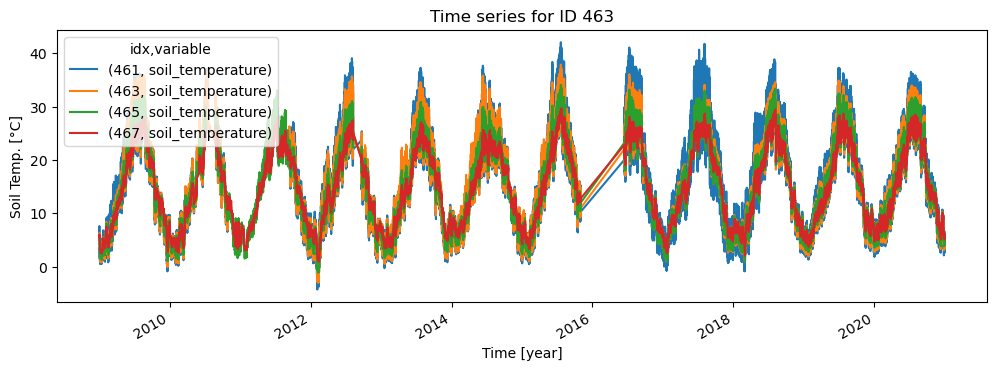

In [17]:
ts, meta = ismn_data.read(ids, return_meta=True)
ax = ts.plot(figsize=(12,4), title=f'Time series for ID {ids[1]}', xlabel="Time [year]", ylabel="Soil Temp. [°C]")

### Plot station locations
We can define a similar query to plot station locations for a specific variable on a map. If a min/max depth is passed, only stations with a sensor that measures within the passed range are included. Note that this kind of visualisation needs additional (optional) packages installed (use `conda` to install `matplotlib` and `cartopy`).

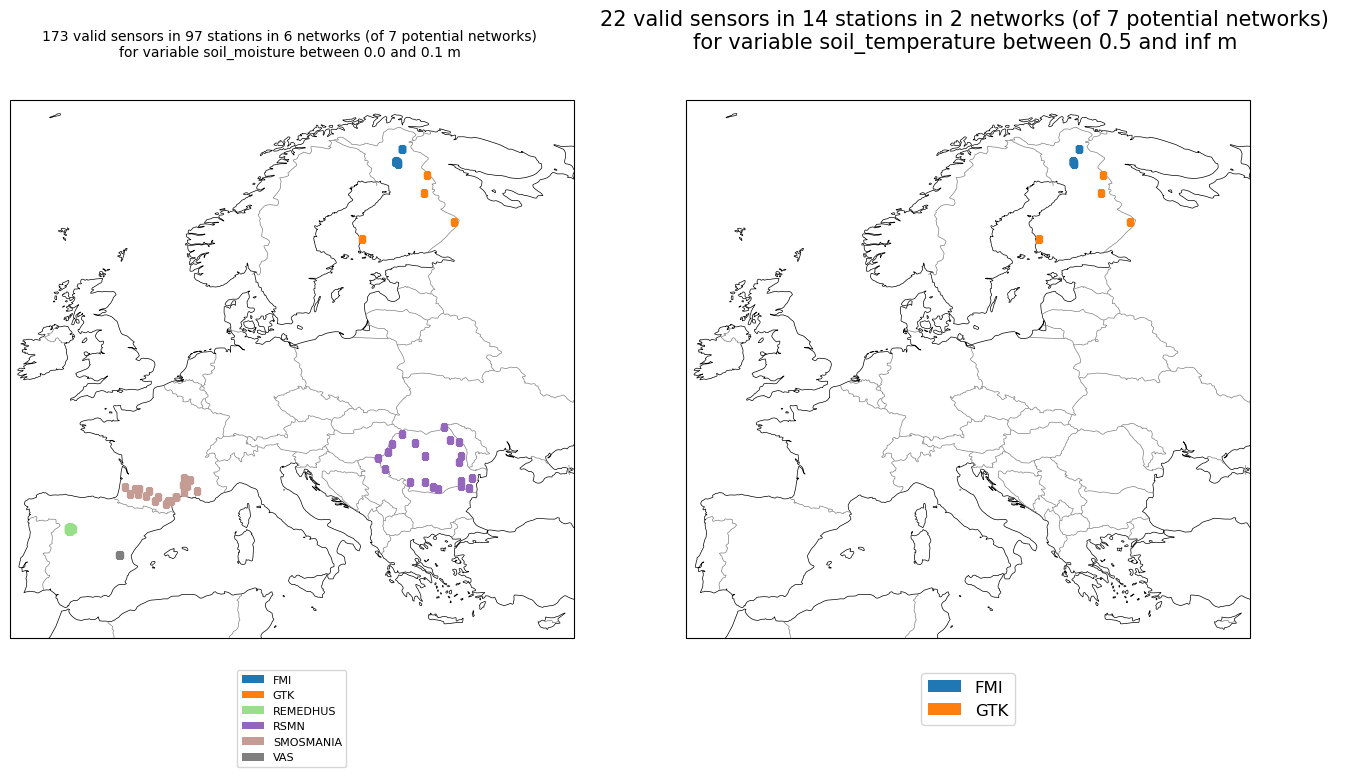

In [20]:
import cartopy.crs as ccrs
#plot available station on a map
fig, axs = plt.subplots(1, 2, figsize=(16,10), subplot_kw={'projection': ccrs.Robinson()})
ismn_data.plot_station_locations('soil_moisture', min_depth=0., max_depth=0.1, ax=axs[0], markersize=5, text_scalefactor=2)
ismn_data.plot_station_locations('soil_temperature', min_depth=0.5, ax=axs[1], markersize=5, text_scalefactor=3)
axs[0].set_extent([-10, 35, 34, 71])
axs[1].set_extent([-10, 35, 34, 71])
plt.show()


### Network data citations/references
When using ISMN data in a publication, please cite:

- Dorigo, W., Himmelbauer, I., Aberer, D., Schremmer, L., Petrakovic, I., Zappa, L., Preimesberger, W., Xaver, A., Annor, F., Ardö, J., Baldocchi, D., Bitelli, M., Blöschl, G., Bogena, H., Brocca, L., Calvet, J.-C., Camarero, J. J., Capello, G., Choi, M., Cosh, M. C., van de Giesen, N., Hajdu, I., Ikonen, J., Jensen, K. H., Kanniah, K. D., de Kat, I., Kirchengast, G., Kumar Rai, P., Kyrouac, J., Larson, K., Liu, S., Loew, A., Moghaddam, M., Martínez Fernández, J., Mattar Bader, C., Morbidelli, R., Musial, J. P., Osenga, E., Palecki, M. A., Pellarin, T., Petropoulos, G. P., Pfeil, I., Powers, J., Robock, A., Rüdiger, C., Rummel, U., Strobel, M., Su, Z., Sullivan, R., Tagesson, T., Varlagin, A., Vreugdenhil, M., Walker, J., Wen, J., Wenger, F., Wigneron, J. P., Woods, M., Yang, K., Zeng, Y., Zhang, X., Zreda, M., Dietrich, S., Gruber, A., van Oevelen, P., Wagner, W., Scipal, K., Drusch, M., and Sabia, R.: **The International Soil Moisture Network: serving Earth system science for over a decade, Hydrol. Earth Syst. Sci., 25, 5749–5804, https://doi.org/10.5194/hess-25-5749-2021, 2021.**

In addition, it is required that you cite the networks you use. Information on how to cite a network can be found on https://ismn.earth/en/networks/ and in the downloaded README file that is provided together with the data.
The ISMN package provides functions to export citations for a single network, and for all networks in a collection (e.g. in case you don't use all the networks you downloaded before) as plain text.

In [21]:
ismn_data['WEGENERNET'].get_citations()

['Kirchengast, G., Kabas, T., Leuprecht, A., Bichler, C. & Truhetz, H. (2014), ‘Wegenernet: A pioneering high-resolution network for monitoring weather and climate’, Bulletin of the American Meteorological Society 95.',
 'Fuchsberger, J., Kirchengast, G. & Kabas, T. (2020), ‘Wegenernet high-resolution weather and climate data 2007 to 2019’, Earth System Science Data Discussions 2020, 1–49.']

In [22]:
ismn_data.collection.export_citations(out_file='/tmp/citations_for_my_subset.txt')

OrderedDict([('FMI',
              ['Ikonen, J., Smolander, T., Rautiainen, K., Cohen, J., Lemmetyinen, J., Salminen, M. & Pulliainen, J. (2018), ‘Spatially distributed evaluation of esa cci soil moisture products in a northern boreal forest environment’, Geosciences 8(2), 51.',
               'Ikonen, J., Vehvilaeinen, J., Rautiainen, K., Smolander, T., Lemmetyinen, J., Bircher, S. & Pulliainen, J. (2015), ‘The sodankylae in-situ soil moisture observation network: an example application to earth observation data product evaluation’, GID 5(2), 599–629.']),
             ('GTK',
              ['We acknowledge the work of Pekka Haenninen, Raimo Sutinen in support of the ISMN.']),
             ('REMEDHUS',
              ['Gonzalez-Zamora, A., Sanchez, N., Pablos, M. & Martinez-Fernandez, J. (2018), ‘Cci soil moisture assessment with smos soil moisture and in situ data under different environmental conditions and spatial scales in spain’, Remote Sensing of Environment 225.']),
             

## Selecting and iterating over sensors

It is often desired to iterate over all sensors that fulfill certain requirements (e.g. that measure soil moisture in a certain depth, and/or for a certain land cover class). For these cases the `collection` (and other components) provide iterators that take keywords and values for filtering the loaded networks/stations/sensor and iterating over the filtered data (of a whole collection, a network, or a station).

### Select by variable and depth
In this example we iterate over all sensors in the previously loaded collection (i.e. over all activated networks) that measure 'soil_moisture' in any depth (range) between 0 and 0.05 meters.

Network 'FMI' with Stations: ['SAA111', 'SAA112', 'SAA120', 'SOD011', 'SOD012', 'SOD013', 'SOD021', 'SOD022', 'SOD023', 'SOD031', 'SOD032', 'SOD033', 'SOD071', 'SOD072', 'SOD073', 'SOD081', 'SOD082', 'SOD083', 'SOD091', 'SOD092', 'SOD093', 'SOD101', 'SOD102', 'SOD103', 'SOD130', 'SOD140', 'SODAWS']

Station 'SAA111' with Sensors: ['5TE_soil_moisture_0.050000_0.050000', '5TE_soil_temperature_0.050000_0.050000', '5TE_soil_moisture_0.100000_0.100000', '5TE_soil_temperature_0.100000_0.100000', '5TE_soil_moisture_0.200000_0.200000', '5TE_soil_temperature_0.200000_0.200000', '5TE_soil_moisture_0.400000_0.400000', '5TE_soil_temperature_0.400000_0.400000', '5TE_soil_moisture_0.800000_0.800000', '5TE_soil_temperature_0.800000_0.800000', 'CS215_air_temperature_-2.000000_-2.000000']

5TE_soil_moisture_0.050000_0.050000

Metadata for sensor 5TE_soil_moisture_0.050000_0.050000:


variable        key       
clay_fraction   val                           4.0
                depth_from                    0.0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                         441.0
instrument      val                           5TE
                depth_from                   0.05
                depth_to                     0.05
latitude        val                      68.33019
lc_2000         val                           110
lc_2005         val                           110
lc_2010         val                           110
lc_insitu       val                       unknown
longitude       val                      27.55062
network         val                           FMI
organic_carbon  val                          2.18
                depth_from                    0.0
                depth_to                      0.3
sand_fraction   val    

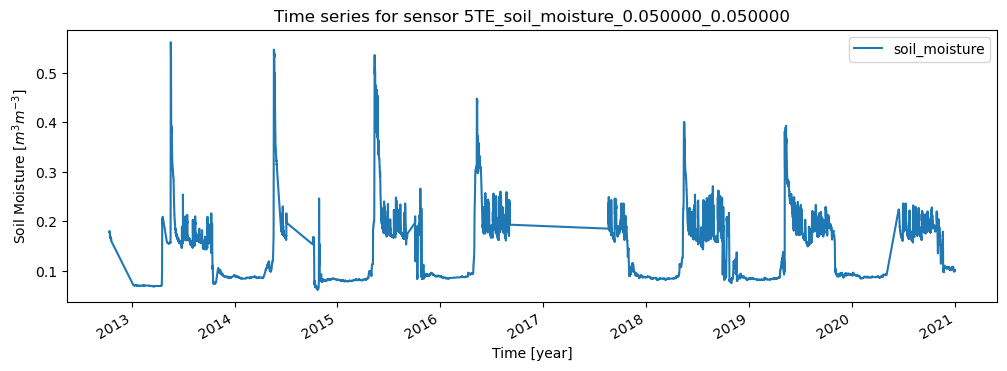

In [23]:
for network, station, sensor in ismn_data.collection.iter_sensors(variable='soil_moisture', 
                                                                  depth=[0., 0.05]):
    display(network)
    display(station)
    display(sensor)

    print('\033[1m' + f'Metadata for sensor {sensor}:'+ '\033[0m')
    display(sensor.metadata.to_pd())
    ax = sensor.data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break  # for this example we stop after the first sensor

### Selecting by variable and other metadata (1)
In this example we iterate over all sensors for the network 'RMSN' and filter out those that measure precipitation within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130). Available land cover classes to choose are:

In [24]:
ismn_data.print_landcover_dict()

CCI Landcover Classification
----------------------------
Cropland, rainfed: 10
Cropland, rainfed / Herbaceous cover: 11
Cropland, rainfed / Tree or shrub cover: 12
Cropland, irrigated or post-flooding: 20
Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous: 30
Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%): 40
Tree cover, broadleaved, evergreen, Closed to open (>15%): 50
Tree cover, broadleaved, deciduous, Closed to open (>15%): 60
Tree cover, broadleaved, deciduous, Closed (>40%): 61
Tree cover, broadleaved, deciduous, Open (15-40%): 62
Tree cover, needleleaved, evergreen, closed to open (>15%): 70
Tree cover, needleleaved, evergreen, closed (>40%): 71
Tree cover, needleleaved, evergreen, open (15-40%): 72
Tree cover, needleleaved, deciduous, closed to open (>15%): 80
Tree cover, needleleaved, deciduous, closed (>40%): 81
Tree cover, needleleaved, deciduous, open (15-40%): 82
Tree cover, mixed leaf type (broadleaved and needleleave

Station 'Barlad' with Sensors: ['5TM_soil_moisture_0.000000_0.050000', '5TM_soil_temperature_0.000000_0.050000', 'HMP155-Vaisala_air_temperature_-2.000000_-2.000000', 'QMR102_precipitation_-1.400000_-1.400000', 'HMP155_air_temperature_-2.000000_-2.000000']

QMR102_precipitation_-1.400000_-1.400000

Metadata for sensor QMR102_precipitation_-1.400000_-1.400000:


variable        key       
climate_KG      val                           Dfb
climate_insitu  val                       unknown
elevation       val                         172.0
instrument      val                        QMR102
                depth_from                   -1.4
                depth_to                     -1.4
latitude        val                      46.23313
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                      27.64438
network         val                          RSMN
station         val                        Barlad
timerange_from  val           2014-06-06 07:00:00
timerange_to    val           2020-12-31 23:00:00
variable        val                 precipitation
                depth_from                   -1.4
                depth_to                     -1.4
Name: data, dtype: obje

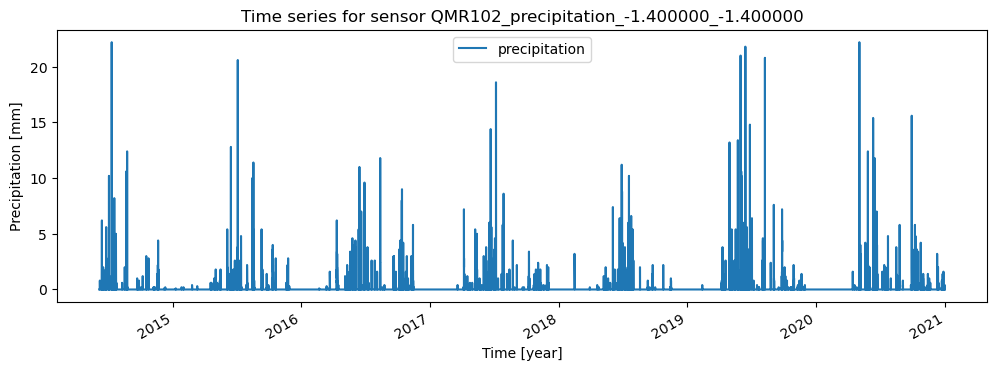

In [25]:
for station, sensor in ismn_data['RSMN'].iter_sensors(variable='precipitation', 
                                                      filter_meta_dict={'lc_2010': [10, 130]}):
    display(station)
    display(sensor)
    
    data = sensor.read_data()
    metadata = sensor.metadata
    
    print('\033[1m' + f'Metadata for sensor {sensor}:' + '\033[0m')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f'Time series for sensor {sensor.name}')
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Precipitation [mm]")
    break # for this example we stop after the first sensor

### Selecting by variable, depth and metadata (2)
In this example we iterate over all sensors in the collection and filter those that measure 'soil_moisture' between 0 and 10 cm within an ESA CCI Landcover pixel that is marked as 'Cropland, rainfed' (10) or 'Grassland' (130), and has one of the following climate classes assigned: 'Csc', 'Cfa', 'Dfc'. In addition, we set all those soil moisture values that are **not** flagged as 'good' (G) to 'NaN'.

In [26]:
ismn_data.print_climate_dict()

KOEPPEN GEIGER Climate Classification
-------------------------------------
Af  : Tropical Rainforest
Am  : Tropical Monsoon
As  : Tropical Savanna Dry
Aw  : Tropical Savanna Wet
BWk : Arid Desert Cold
BWh : Arid Desert Hot
BWn : Arid Desert With Frequent Fog
BSk : Arid Steppe Cold
BSh : Arid Steppe Hot
BSn : Arid Steppe With Frequent Fog
Csa : Temperate Dry Hot Summer
Csb : Temperate Dry Warm Summer
Csc : Temperate Dry Cold Summer
Cwa : Temperate Dry Winter, Hot Summer
Cwb : Temperate Dry Winter, Warm Summer
Cwc : Temperate Dry Winter, Cold Summer
Cfa : Temperate Without Dry Season, Hot Summer
Cfb : Temperate Without Dry Season, Warm Summer
Cfc : Temperate Without Dry Season, Cold Summer
Dsa : Cold Dry Summer, Hot Summer
Dsb : Cold Dry Summer, Warm Summer
Dsc : Cold Dry Summer, Cold Summer
Dsd : Cold Dry Summer, Very Cold Winter
Dwa : Cold Dry Winter, Hot Summer
Dwb : Cold Dry Winter, Warm Summer
Dwc : Cold Dry Winter, Cold Summer
Dwd : Cold Dry Winter, Very Cold Winter
Dfa : Cold Dry

Network 'RSMN' with Stations: ['Adamclisi', 'Alexandria', 'Bacles', 'Banloc', 'Barlad', 'Calarasi', 'ChisineuCris', 'Corugea', 'Cotnari', 'Darabani', 'Dej', 'Dumbraveni', 'Iasi', 'Oradea', 'RosioriideVede', 'SannicolauMare', 'SatuMare', 'Slatina', 'Slobozia', 'Tecuci']

Station 'Dumbraveni' with Sensors: ['5TM_soil_moisture_0.000000_0.050000', '5TM_soil_temperature_0.000000_0.050000', 'HMP45DX_air_temperature_-2.000000_-2.000000', 'QMR102_precipitation_-1.400000_-1.400000']

5TM_soil_moisture_0.000000_0.050000

Metadata for sensor 5TM_soil_moisture_0.000000_0.050000:


variable        key       
clay_fraction   val                          19.0
                depth_from                    0.0
                depth_to                      0.3
climate_KG      val                           Dfc
climate_insitu  val                       unknown
elevation       val                         318.0
instrument      val                           5TM
                depth_from                    0.0
                depth_to                     0.05
latitude        val                      46.22786
lc_2000         val                            10
lc_2005         val                            10
lc_2010         val                            10
lc_insitu       val                       unknown
longitude       val                      24.59161
network         val                          RSMN
organic_carbon  val                          0.99
                depth_from                    0.0
                depth_to                      0.3
sand_fraction   val    

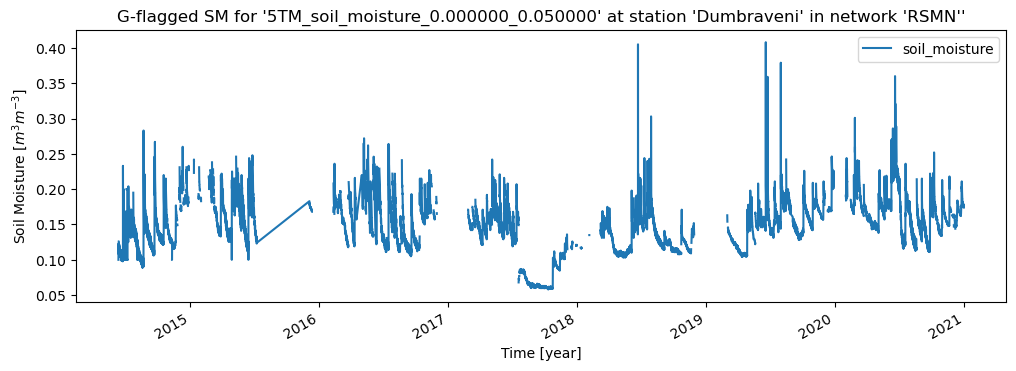

In [27]:
from ismn.meta import Depth
for network, station, sensor in ismn_data.collection \
    .iter_sensors(variable='soil_moisture',
                  depth=Depth(0.,0.05),
                  filter_meta_dict={'lc_2010': [10, 130],
                                    'climate_KG':['Csc', 'Cfa', 'Dfc']}):
    
    display(network)
    display(station)
    display(sensor)
    
    data = sensor.read_data()
    data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
    metadata = sensor.metadata

    print('\033[1m' + f'Metadata for sensor {sensor}:'+ '\033[0m')
    display(metadata.to_pd())
    ax = data.plot(figsize=(12,4), title=f"G-flagged SM for '{sensor.name}' at station '{station.name}' in network '{network.name}''")
    ax.set_xlabel("Time [year]")
    ax.set_ylabel("Soil Moisture [$m^3 m^{-3}$]")
    break # for this example we stop after the first sensor

### Creating subset Interface
`ISMN_Interface` has a method to create a subset of itself. A subset can consist of any number of sensors from any stations or networks that were in the original object. A subset is again created by passing a number of IDs. IDs can again be retrieved either from the metadata frame (which hold all the information on the sensors) or the `ISMN_Interface.get_dataset_ids` method see chapter [Selecting and reading specific sensors](#read_from_meta)). Here we randomly pick 10 soil moisture sensors. We then create a subset for these ids and use all the available `ISMN_Interface` functions, e.g. to plot the subset.

In [28]:
metadata = ismn_data.metadata[ismn_data.metadata[('variable', 'val')] == 'soil_moisture']
np.random.seed(123)
ids = np.random.choice(metadata.index, 10)
subset = ismn_data.subset_from_ids(ids)
subset

Found existing ismn metadata in /tmp/python_metadata/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.csv.


ismn.base.IsmnRoot Zip at /tmp/Data_separate_files_header_20090101_20201231_9289_Cwpc_20221201.zip
with Networks[Stations]:
------------------------
  GTK: ['IlomantsiII', 'PoriII'],
  SMOSMANIA: ['Mouthoumet', 'Mejannes-le-Clap'],
  FMI: ['SOD011', 'SOD140', 'SOD083'],
  REMEDHUS: ['Guarena']

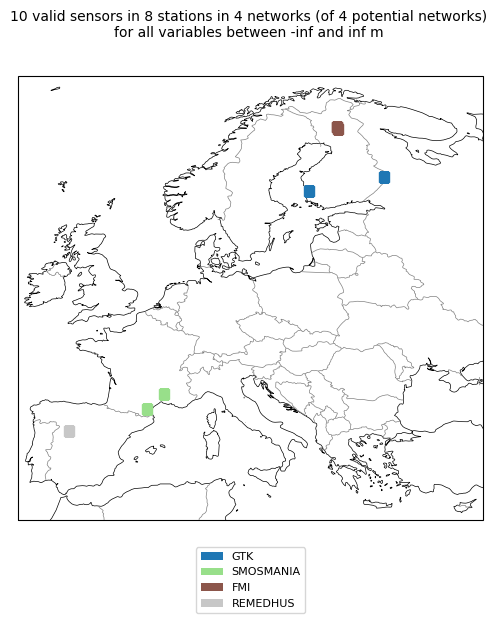

In [31]:
import cartopy.crs as ccrs
#plot available station on a map
fig, ax = plt.subplots(1, 1, figsize=(6,8), subplot_kw={'projection': ccrs.Robinson()})
subset.plot_station_locations(ax=ax, markersize=7, text_scalefactor=2)
ax.set_extent([-10, 35, 34, 71])
plt.show()